In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
import sys

import mlflow
import numpy as np
import scanpy as sc
import squidpy as sq

from autotalker.data import load_spatial_adata_from_csv
from autotalker.models import Autotalker
from autotalker.utils import add_gps_from_gp_dict_to_adata
from autotalker.utils import extract_gp_dict_from_nichenet_ligand_target_mx
from autotalker.utils import extract_gp_dict_from_omnipath_lr_interactions

In [3]:
dataset = "squidpy_seqfish"

In [4]:
print(f"Using dataset {dataset}.")

if dataset == "deeplinc_seqfish":
    adata = load_spatial_adata_from_csv("datasets/seqFISH/counts.csv",
                                        "datasets/seqFISH/adj.csv")
    cell_type_key = None
elif dataset == "squidpy_seqfish":
    adata = sq.datasets.seqfish()
    sq.gr.spatial_neighbors(adata, radius = 0.04, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"
elif dataset == "squidpy_slideseqv2":
    adata = sq.datasets.slideseqv2()
    sq.gr.spatial_neighbors(adata, radius = 30.0, coord_type="generic")
    cell_type_key = "cluster"

Using dataset squidpy_seqfish.


In [5]:
print(f"Number of nodes: {adata.X.shape[0]}")
print(f"Number of node features: {adata.X.shape[1]}")
avg_edges_per_node = round(
    adata.obsp['spatial_connectivities'].toarray().sum(axis=0).mean(),2)
print(f"Average number of edges per node: {avg_edges_per_node}")
n_edges = int(np.triu(adata.obsp['spatial_connectivities'].toarray()).sum())
print(f"Number of edges: {n_edges}", sep="")

Number of nodes: 19416
Number of node features: 351
Average number of edges per node: 4.4
Number of edges: 42694


In [6]:
os.makedirs("mlruns", exist_ok=True)

In [7]:
experiment = mlflow.set_experiment("autotalker")
mlflow.log_param("dataset", dataset)

In [10]:
node_label_method = "self"
n_latent = 32

# Mask that allows all genes
if node_label_method == "self":
    n_output = len(adata.var)
elif node_label_method == "one-hop":
    n_output = len(adata.var) * 2
    
mask = np.ones((n_latent, n_output))
print(mask.shape)

(32, 351)


In [ ]:
model = Autotalker(adata,
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_gp_targets",
                   gp_sources_mask_key="autotalker_gp_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=32,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=mask,
                   gp_sources_mask=None)

In [ ]:
model.train(n_epochs=20,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            node_test_ratio=0.0,
            edge_batch_size=64,
            mlflow_experiment_id=experiment.experiment_id)

In [ ]:
model.save(dir_path="./model_artefacts",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

In [ ]:
model = Autotalker.load(dir_path="./model_artefacts",
                        adata=None,
                        adata_file_name="adata.h5ad")

In [ ]:
latent = model.get_latent_representation()

In [ ]:
latent_new_data = model.get_latent_representation(adata)

In [ ]:
adata.obsm["latent_autotalker"] = latent_new_data

## Interoperability with scanpy

In [ ]:
sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save="_latent.png")

## Add Explainable Cell-Cell-Interaction Gene Programs (GPs)

In [11]:
gp_data_folder_path = "datasets/gp_data"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

os.makedirs(gp_data_folder_path, exist_ok=True)

### NicheNet

In [12]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.1,
    load_from_disk=True,
    save_to_disk=True,
    file_path=nichenet_ligand_target_mx_file_path)

In [13]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=nichenet_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_gp_targets",
    gp_sources_varm_key="autotalker_gp_sources",
    gp_names_uns_key="autotalker_gp_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

### OmniPath

In [14]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=True,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [15]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=omnipath_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_gp_targets",
    gp_sources_varm_key="autotalker_gp_sources",
    gp_names_uns_key="autotalker_gp_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

### NicheNet & OmniPath Combined

In [16]:
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)

In [17]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=combined_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_gp_targets",
    gp_sources_varm_key="autotalker_gp_sources",
    gp_names_uns_key="autotalker_gp_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [18]:
adata.varm["autotalker_gp_targets"]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [19]:
adata.varm["autotalker_gp_sources"]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [20]:
adata.uns["autotalker_gp_names"][:5]

['CXCL1_ligand_targetgenes_GP',
 'CXCL2_ligand_targetgenes_GP',
 'CXCL3_ligand_targetgenes_GP',
 'CXCL5_ligand_targetgenes_GP',
 'PPBP_ligand_targetgenes_GP']

In [21]:
experiment = mlflow.set_experiment("autotalker_gp_masked")
mlflow.log_param("dataset", dataset)

In [ ]:
gp_mask = adata.varm["autotalker_gps"].T
print(f"Gene program mask shape (gene programs x nodes): {gp_mask.shape}")
n_hidden_encoder = int(gp_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {n_hidden_encoder}")

In [22]:
model = Autotalker(adata,
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_gp_targets",
                   gp_sources_mask_key="autotalker_gp_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   node_label_method="one-hop",
                   n_hidden_encoder=32,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
GCN ENCODER -> n_input: 351, n_hidden: 32, n_latent: 769, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 769, n_output: 702


In [23]:
model.train(n_epochs=20,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            node_test_ratio=0.0,
            edge_batch_size=64,
            mlflow_experiment_id=experiment.experiment_id)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of test nodes: 0
Number of training edges: 36291
Number of validation edges: 4269
Number of test edges: 2134

--- MODEL TRAINING ---
Epoch 1/20 |█-------------------| 5.0% val_auroc_score: 0.7600; val_auprc_score: 0.6765; val_best_acc_score: 0.5350; val_best_f1_score: 0.6826; train_loss: 1466.1686; train_edge_recon_loss: 6.6937; train_kl_loss: 0.3464; train_gene_expr_recon_loss: 1459.1286; val_loss: 1352.1879; val_edge_recon_loss: 4.5852; val_kl_loss: 0.3696; val_gene_expr_recon_loss: 1347.2331
Epoch 2/20 |██------------------| 10.0% val_auroc_score: 0.8706; val_auprc_score: 0.7987; val_best_acc_score: 0.5440; val_best_f1_score: 0.6867; train_loss: 1346.6132; train_edge_recon_loss: 4.0360; train_kl_loss: 0.4472; train_gene_expr_recon_loss: 1342.1300; val_loss: 1340.5752; val_edge_recon_loss: 3.2781; val_kl_loss: 0.4033; val_gene_expr_recon_loss: 1336.8938
Epoch 3/20 |███----------------

The model can maintain the edge reconstruction performance while tweaking the latent space for better gene expression reconstruction.

In [24]:
latent_gps = model.get_latent_representation()

In [25]:
latent_gps_new_adata = model.get_latent_representation(adata)

In [26]:
adata.obsm["latent_gps_autotalker"] = latent_gps_new_adata

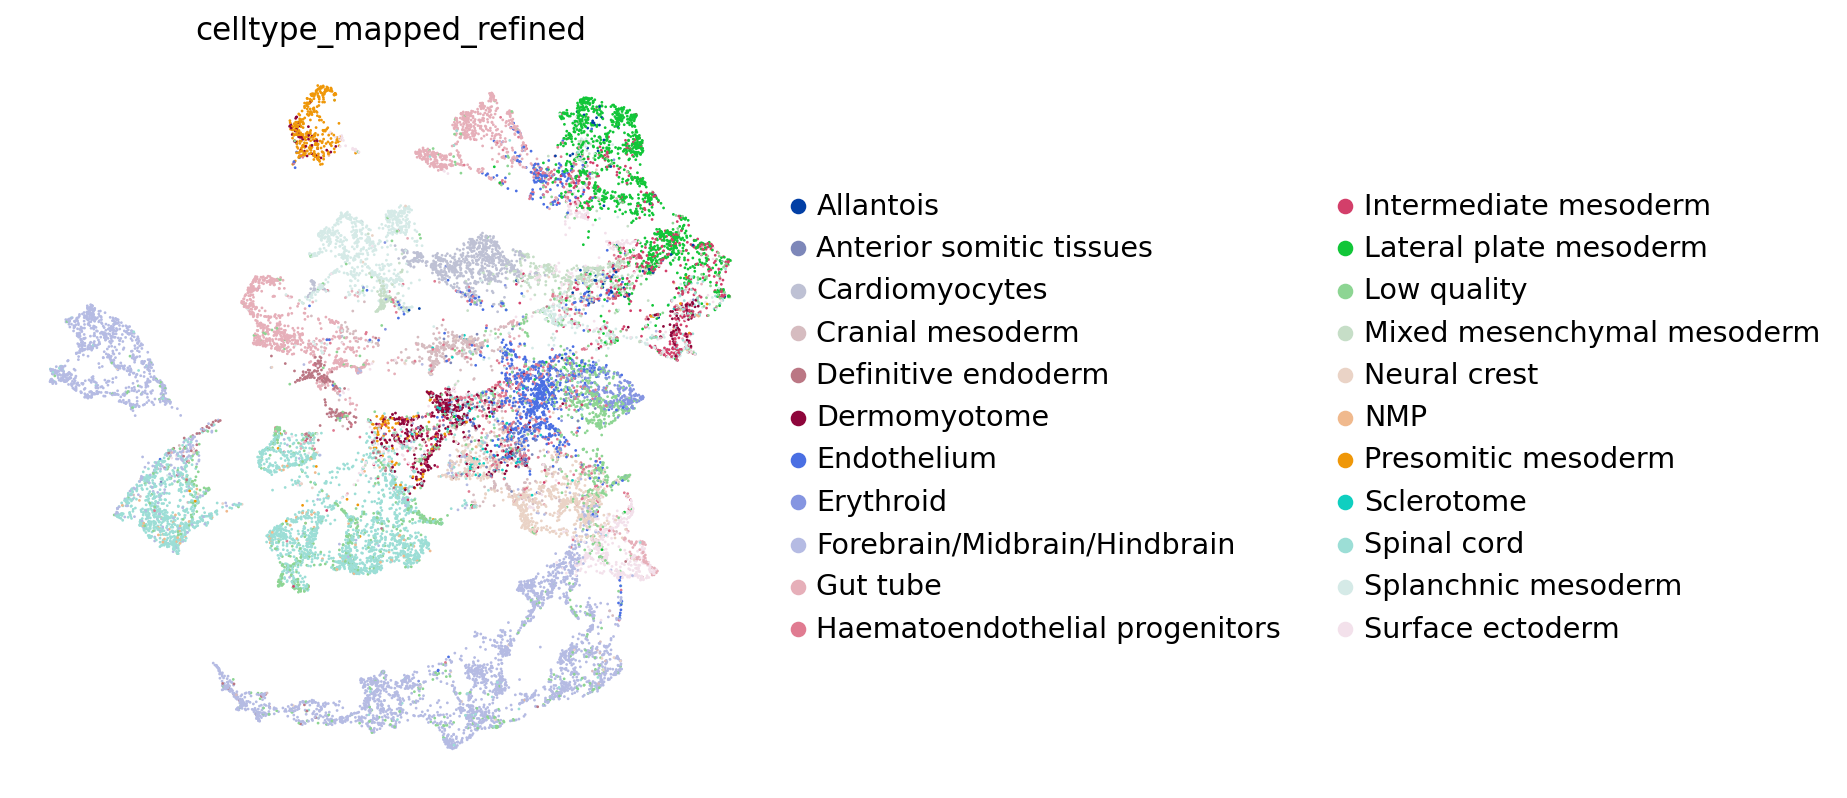

In [27]:
sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent gp space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_gps_autotalker")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False)

In [ ]:
gp_mask.shape

In [ ]:
gene_programs = adata.uns["gene_programs"]
selected_gene_programs = ["CSF1", "IL34"]
selected_gene_programs_idx = [gene_programs.index(gene_program) for gene_program in selected_gene_programs]

In [ ]:
latent_selected_gps = latent_gps[:, selected_gene_programs_idx]

In [ ]:
adata.obs["CSF1"] = latent_selected_gps[:, 0]
adata.obs["IL34"] = latent_selected_gps[:, 1]

In [ ]:
sc.pl.umap(adata, color="IL34", frameon=False, wspace=0.6)

In [ ]:
sc.pl.scatter(adata, x="CSF1", y="IL34", color=cell_type_key, size=10)

## SCVI

In [ ]:
import scvi
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(6, 6))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [ ]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts"
)

In [ ]:
model = scvi.model.SCVI(adata)

In [ ]:
model

In [ ]:
model.train()

In [ ]:
latent_scvi = model.get_latent_representation()

In [ ]:
adata.obsm["X_scVI"] = latent_scvi

In [ ]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

In [ ]:
sc.pl.umap(adata, color=["celltype_mapped_refined"], frameon=False,)